In [78]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import re, string
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [79]:
# adding the training urls

train_url = 'https://drive.google.com/file/d/1F1fDHnvDMEopHYaulMQYNy1SCpEenoFr/view?usp=sharing'
train_url_ = 'https://drive.google.com/uc?id=' + train_url.split('/')[-2]

In [80]:
# adding the testing urls
test_url = 'https://drive.google.com/file/d/1hxMss3XPtA4x3iOcqUjPkYqRKahOIo2B/view?usp=sharing'
test_url_ = 'https://drive.google.com/uc?id=' + test_url.split('/')[-2]

In [81]:
print('my training link:', train_url_)
print('my testing link:', test_url_)

my training link: https://drive.google.com/uc?id=1F1fDHnvDMEopHYaulMQYNy1SCpEenoFr
my testing link: https://drive.google.com/uc?id=1hxMss3XPtA4x3iOcqUjPkYqRKahOIo2B


In [82]:
# reading the files

df_train = pd.read_csv(train_url_, header= None) # got the dataframe
df_test = pd.read_csv(test_url_, header= None)
print(df_train.head())

            0                                                  1
0  __label__0  study interventions are recombinant CD40-ligan...
1  __label__0  study interventions are Liposomal doxorubicin ...
2  __label__0  study interventions are BI 836909 . multiple m...
3  __label__0  study interventions are Immunoglobulins . recu...
4  __label__0  study interventions are Paclitaxel . stage ova...


In [83]:
# now we are workking with the second column (main data)

train_data_set = df_train[1]
test_data_set = df_test[1]

print(type(train_data_set),'\n', train_data_set[:5])

<class 'pandas.core.series.Series'> 
 0    study interventions are recombinant CD40-ligan...
1    study interventions are Liposomal doxorubicin ...
2    study interventions are BI 836909 . multiple m...
3    study interventions are Immunoglobulins . recu...
4    study interventions are Paclitaxel . stage ova...
Name: 1, dtype: object


In [84]:
# working with labels

train_label = []
test_label = []

# in order to the program to distinguish labels

for label in list(df_train[0]):
    if label == '__label__0':
        train_label.append(0)
    if label == '__label__1':
        train_label.append(1)

for label_test in list(df_test[0]):
    if label_test == '__label__0':
        test_label.append(0)
    if label_test == '__label__1':
        test_label.append(1)

# print(type(train_label), len(train_label))
# print(type(test_label))

y_train = np.asarray(train_label).astype("float32")
y_test = np.asarray(test_label).astype("float32")

print('type,length of training labels:', type(y_train),len(y_train), y_train)

type,length of training labels: <class 'numpy.ndarray'> 9907 [0. 0. 0. ... 1. 1. 1.]


In [85]:
# preprocessing text 

stop_words = stopwords.words("english")

def cleaning(data):
    
    filtered = re.sub("@\S+", " ", data)  # remove mentions
    filtered = re.sub("https*\S+", " ", filtered) # remove url
    filtered = re.sub("#\S+", " ", filtered) # remove hashtags
    filtered = re.sub("\d", " ", filtered) # remove all numbers
    filtered = re.sub('[%s]' % re.escape(string.punctuation), ' ', filtered)  # remove punctuation
    filtered = re.sub('\n', ' ', filtered) # remove new lines       
    filtered = re.sub('\s{2,}',' ', filtered) # remove extra spaces
    
    filtered = filtered.lower()
    
    filtered = ' '.join([word for word in filtered.split(' ') if word not in stop_words])
    
    return filtered

cleaned_train = train_data_set.apply(cleaning)
cleaned_test = test_data_set.apply(cleaning)
 
print(type(cleaned_train), '\n', cleaned_train[:5])

<class 'pandas.core.series.Series'> 
 0    study interventions recombinant cd ligand mela...
1    study interventions liposomal doxorubicin colo...
2    study interventions bi multiple myeloma diagno...
3    study interventions immunoglobulins recurrent ...
4    study interventions paclitaxel stage ovarian c...
Name: 1, dtype: object


In [86]:
train_in_string = ''
for i in cleaned_train:
    train_in_string += (' ' + i)
    
test_in_string = ''
for j in cleaned_test:
    test_in_string += (' ' + j)
    
all_data = train_in_string + test_in_string

In [87]:


tokenization = word_tokenize(all_data)
lemmatizer = WordNetLemmatizer()
lemmatized_all_data = [lemmatizer.lemmatize(t) for t in tokenization]
dictionary = list(set(lemmatized_all_data))

# func is showing the dataframe of word indexes
def lemmatization(data):

    data = data.lower()
    tokens = word_tokenize(data)
    lemmatized = [lemmatizer.lemmatize(l) for l in tokens]
    res = [dictionary.index(i) for i in lemmatized]
    return res
    

x_train_data = cleaned_train.apply(lemmatization)
x_test_data = cleaned_test.apply(lemmatization)

print('x_train_data type:', type(x_train_data))
print('x_test_data type:', type(x_test_data))

# print(type(x_test_data), len(x_test_data))

x_train_data type: <class 'pandas.core.series.Series'>
x_test_data type: <class 'pandas.core.series.Series'>


In [88]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [89]:

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [90]:
vocab_size = 10000 # Only consider the top 20k words
maxlen = 50  # Only consider the first 200 words of each movie review

x_train = keras.preprocessing.sequence.pad_sequences(x_train_data, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test_data, maxlen=maxlen)

print(len(x_train), "Training sequences")
print(len(x_test), "Validation sequences")

9907 Training sequences
1000 Validation sequences


In [91]:
embed_dim = 64  # Embedding size for each token
num_heads = 4 # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


print(x_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   18 4201 1811 2429 6614 4460
 5890 1393 4215 4501 2674 2188 2117  925]


In [92]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(len(y_train))
history = model.fit(
    x_train, y_train, batch_size=64, epochs=6, validation_split = 0.1, shuffle = True
)



9907
Epoch 1/6
140/140 [==============================] - 7s 43ms/step - loss: 0.6191 - accuracy: 0.6382 - val_loss: 0.2311 - val_accuracy: 0.9374
Epoch 2/6
140/140 [==============================] - 6s 42ms/step - loss: 0.4226 - accuracy: 0.8192 - val_loss: 0.4148 - val_accuracy: 0.8507
Epoch 3/6
140/140 [==============================] - 6s 42ms/step - loss: 0.3341 - accuracy: 0.8656 - val_loss: 0.4229 - val_accuracy: 0.7952
Epoch 4/6
140/140 [==============================] - 6s 42ms/step - loss: 0.2803 - accuracy: 0.8909 - val_loss: 0.5324 - val_accuracy: 0.7578
Epoch 5/6
140/140 [==============================] - 6s 42ms/step - loss: 0.2409 - accuracy: 0.9124 - val_loss: 0.4203 - val_accuracy: 0.8264
Epoch 6/6
140/140 [==============================] - 6s 42ms/step - loss: 0.1964 - accuracy: 0.9250 - val_loss: 0.6356 - val_accuracy: 0.7689


In [93]:
print(model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50)]              0         
                                                                 
 token_and_position_embeddin  (None, 50, 64)           643200    
 g_4 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_4 (Transf  (None, 50, 64)           74944     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_4   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_18 (Dropout)        (None, 64)                0   

In [94]:

score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])


Test score: 0.38903987407684326
Test accuracy: 0.8679999709129333


In [95]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

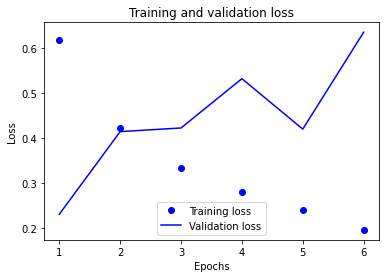

In [96]:

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [1]:
"""Здравствуйте, Наталья! Сейчас на экране вы видите результат 0.87.. но на самом деле у меня получилось добиться результата ~0.88, дажеесть скриншот!!! там видно использование слоев трансформера :)"""

'Здравствуйте, Наталья! Сейчас на экране вы видите результат 0.86.. но на самом деле у меня получилось добиться результата ~0.88, дажеесть скриншот!!! там видно использование слоев трансформера :)'